In [2]:
import glob
import json
import pandas as pd
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

filenames = glob.glob("/home/hugo/Thèse/listening-tests/resultats/*.json")


def parse(filename):
    filename = filename[:-4]
    return filename.split("-")


rows = []

for filename in filenames:
    listener = Path(filename).stem
    with open(filename, "r") as file:
        data = json.load(file)
        for entry in data:
            distance = entry["result"]
            id = entry["test"]["id"]
            a = entry["test"]["a"]
            b = entry["test"]["b"]

            (violin_a, player_a, session_a) = parse(a)
            (violin_b, player_b, session_b) = parse(b)

            row = {
                "test_id": id,
                "listener": listener,
                "violin_a": violin_a,
                "player_a": player_a,
                "session_a": session_a,
                "violin_b": violin_b,
                "player_b": player_b,
                "session_b": session_b,
                "distance": distance,
            }
            rows.append(row)

df = pd.DataFrame(rows)

# Z transform babyyyy
# df["distance"] = df.groupby("listener")["distance"].transform(
#     lambda x: (x - x.mean()) / x.std()
# )

distance_same = df[
    (df.violin_a == df.violin_b)
    & (df.session_a == df.session_b)
    & (df.player_a == df.player_b)
]

# distance_same = distance_same.rename(
#     columns={
#         "violin_a": "violin_x",
#         "player_a": "player_x",
#         "session_a": "session_x",
#         "violin_b": "violin_y",
#         "player_b": "player_y",
#         "session_b": "session_y",
#     }
# )
# display(distance_same.loc[:, df.columns != "listener"])

display(df)

,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,15,Blaz,C,Norimi,2,C,Norimi,3,8
1,14,Blaz,C,Norimi,1,C,Norimi,2,1
2,10,Blaz,A,Norimi,1,A,Norimi,2,9
3,2,Blaz,B,SMD,2,B,SMD,1,8
4,18,Blaz,A,Norimi,2,A,Norimi,2na,8
...,...,...,...,...,...,...,...,...,...
395,11,Celeste,A,Norimi,1,A,Norimi,3,8
396,18,Celeste,A,Norimi,2na,A,Norimi,2,1
397,14,Celeste,C,Norimi,1,C,Norimi,2,1
398,13,Celeste,B,Norimi,3,B,Norimi,2,6


/tmp/ipykernel_597580/838356492.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


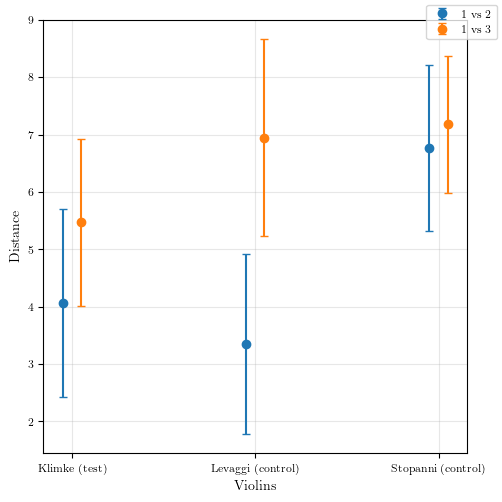

In [5]:
mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, ax = plt.subplots(1, figsize=(5, 5))

for violin_id, violin in enumerate(["A", "B", "C"]):
    entries = df[
        (df.player_a == df.player_b)
        & (df.violin_a == df.violin_b)
        & (df.violin_a == violin)
        & (~df.listener.isin(["Celeste", "Félix", "Norimi"]))
        & (df.player_a == "SMD")
    ]
    d12 = entries[
        (
            (entries.session_a.isin(["1"]) & entries.session_b.isin(["2"]))
            | (entries.session_b.isin(["1"]) & entries.session_a.isin(["2"]))
        )
    ].reset_index()
    d13 = entries[
        (
            (
                entries.session_a.isin(["1", "2", "1na", "2na"])
                & entries.session_b.isin(["3"])
            )
            | (
                entries.session_b.isin(["1", "2", "1na", "2na"])
                & entries.session_a.isin(["3"])
            )
        )
    ].reset_index()

    results1 = d12.distance.aggregate(["mean", "std", "count"])
    results2 = d13.distance.aggregate(["mean", "std", "count"])

    ax.errorbar(
        violin_id - 0.05,
        results1["mean"],
        yerr=1.96 / np.sqrt(results1["count"]) * results1["std"],
        fmt="o",
        color="C0",
        capsize=3,
    )

    ax.errorbar(
        violin_id + 0.05,
        results2["mean"],
        yerr=1.96 / np.sqrt(results2["count"]) * results2["std"],
        fmt="o",
        color="C1",
        capsize=3,
    )

ax.set_ylabel("Distance")
ax.set_xlabel("Violins")
ax.set_xticks([0, 1, 2], ["Klimke (test)", "Levaggi (control)", "Stopanni (control)"])
# ax.set_ylim((4, 8))
fig.legend(("1 vs 2", "1 vs 3"))
fig.show()

# fig.savefig("../reports/figures/tests.png")

/tmp/ipykernel_223187/1866216491.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


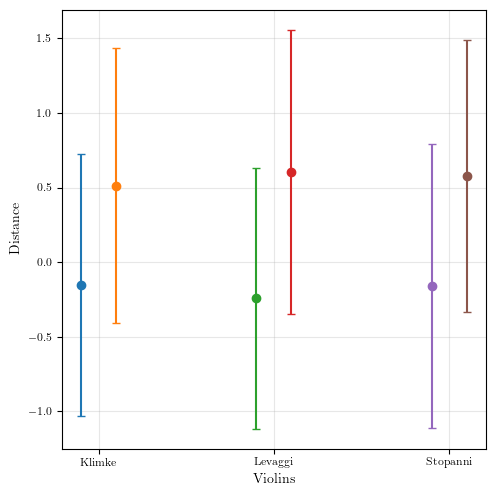

In [ ]:
mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, ax = plt.subplots(1, figsize=(5, 5))

for violin_id, violin in enumerate(["A", "B", "C"]):
    entries = df[
        (df.violin_a == df.violin_b)
        & (df.violin_a == violin)
        & (
            (df.session_a.isin(["1", "2", "1na", "2na"]) & df.session_b.isin(["3"]))
            | (df.session_b.isin(["1", "2", "1na", "2na"]) & df.session_a.isin(["3"]))
        )
        & (~df.listener.isin(["Celeste", "Félix", "Norimi"]))
    ]
    results = entries.distance.aggregate(["mean", "std", "count"])

    d12 = df[
        (df.violin_a == df.violin_b)
        & (df.violin_a == violin)
        & ((df.session_a == "1") & (df.session_b == "2"))
        | ((df.session_a == "2") & (df.session_b == "1"))
    ].distance.aggregate(["mean", "std"])

    d13 = df[
        (df.violin_a == df.violin_b)
        & (df.violin_a == violin)
        & ((df.session_a == "1") & (df.session_b == "3"))
        | ((df.session_a == "3") & (df.session_b == "1"))
    ].distance.aggregate(["mean", "std"])

    ax.errorbar(
        violin_id - 0.1,
        d12["mean"],
        yerr=d12["std"],
        fmt="o",
        capsize=3,
    )

    ax.errorbar(
        violin_id + 0.1,
        d13["mean"],
        yerr=d13["std"],
        fmt="o",
        capsize=3,
    )

    # ax.errorbar(
    #     violin_id,
    #     results["mean"],
    #     yerr=1.96 / np.sqrt(results["count"]) * results["std"],
    #     fmt="o",
    #     capsize=3,
    # )

ax.set_ylabel("Distance")
ax.set_xlabel("Violins")
ax.set_xticks([0, 1, 2], ["Klimke", "Levaggi", "Stopanni"])
# ax.set_ylim((4, 8))
fig.show()
# fig.savefig("../reports/figures/tests.png")

,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,13,1,Blaz,A,SMD,3,A,SMD,1,1.071312
1,37,1,Bernhard,A,SMD,1,A,SMD,3,1.521240
2,43,1,Eugénie,A,SMD,1,A,SMD,3,-1.363063
3,62,1,ruth,A,SMD,3,A,SMD,1,0.960496
4,80,1,Owen,A,SMD,1,A,SMD,3,-0.260333
5,132,1,PaulNoulet,A,SMD,3,A,SMD,1,0.609483
6,154,1,01-Paul,A,SMD,3,A,SMD,1,-0.478571
7,170,1,Roberto,A,SMD,1,A,SMD,3,0.858527
8,189,1,adam,A,SMD,3,A,SMD,1,-0.759264
9,219,1,Elisabeth,A,SMD,1,A,SMD,3,0.450790


,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,6,11,Blaz,A,Norimi,1,A,Norimi,3,1.071312
1,24,11,Bernhard,A,Norimi,3,A,Norimi,1,-1.057133
2,53,11,Eugénie,A,Norimi,1,A,Norimi,3,0.042157
3,65,11,ruth,A,Norimi,1,A,Norimi,3,0.611225
4,91,11,Owen,A,Norimi,3,A,Norimi,1,-1.179156
5,128,11,PaulNoulet,A,Norimi,3,A,Norimi,1,0.312174
6,151,11,01-Paul,A,Norimi,1,A,Norimi,3,0.993955
7,164,11,Roberto,A,Norimi,3,A,Norimi,1,-0.572351
8,182,11,adam,A,Norimi,3,A,Norimi,1,0.408834
9,211,11,Elisabeth,A,Norimi,1,A,Norimi,3,-1.188446


,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,12,3,Blaz,B,SMD,3,B,SMD,1,0.777802
1,25,3,Bernhard,B,SMD,3,B,SMD,1,-0.799296
2,59,3,Eugénie,B,SMD,1,B,SMD,3,1.447376
3,67,3,ruth,B,SMD,3,B,SMD,1,-0.785860
4,85,3,Owen,B,SMD,3,B,SMD,1,0.964764
5,124,3,PaulNoulet,B,SMD,3,B,SMD,1,1.204102
6,143,3,01-Paul,B,SMD,1,B,SMD,3,1.362086
7,174,3,Roberto,B,SMD,3,B,SMD,1,1.717054
8,199,3,adam,B,SMD,3,B,SMD,1,1.576932
9,208,3,Elisabeth,B,SMD,3,B,SMD,1,1.270408


,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,19,13,Blaz,B,Norimi,2,B,Norimi,3,0.777802
1,39,13,Bernhard,B,Norimi,3,B,Norimi,2,-0.799296
2,54,13,Eugénie,B,Norimi,2,B,Norimi,3,0.323200
3,72,13,ruth,B,Norimi,3,B,Norimi,2,0.611225
4,96,13,Owen,B,Norimi,3,B,Norimi,2,-1.485431
5,121,13,PaulNoulet,B,Norimi,2,B,Norimi,3,0.312174
6,148,13,01-Paul,B,Norimi,2,B,Norimi,3,1.730217
7,176,13,Roberto,B,Norimi,2,B,Norimi,3,-0.572351
8,192,13,adam,B,Norimi,3,B,Norimi,2,-1.051288
9,209,13,Elisabeth,B,Norimi,3,B,Norimi,2,1.270408


,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,17,5,Blaz,C,SMD,1,C,SMD,3,0.484292
1,36,5,Bernhard,C,SMD,3,C,SMD,1,1.521240
2,55,5,Eugénie,C,SMD,1,C,SMD,3,1.166332
3,70,5,ruth,C,SMD,1,C,SMD,3,0.960496
4,98,5,Owen,C,SMD,3,C,SMD,1,0.964764
5,134,5,PaulNoulet,C,SMD,3,C,SMD,1,1.204102
6,153,5,01-Paul,C,SMD,1,C,SMD,3,-0.110439
7,178,5,Roberto,C,SMD,1,C,SMD,3,0.572351
8,190,5,adam,C,SMD,3,C,SMD,1,0.700859
9,210,5,Elisabeth,C,SMD,3,C,SMD,1,1.270408


,index,test_id,listener,violin_a,player_a,session_a,violin_b,player_b,session_b,distance
0,0,15,Blaz,C,Norimi,2,C,Norimi,3,0.484292
1,30,15,Bernhard,C,Norimi,2,C,Norimi,3,-1.057133
2,47,15,Eugénie,C,Norimi,2,C,Norimi,3,-1.082019
3,79,15,ruth,C,Norimi,3,C,Norimi,2,1.309767
4,89,15,Owen,C,Norimi,2,C,Norimi,3,0.658490
5,120,15,PaulNoulet,C,Norimi,2,C,Norimi,3,-0.877062
6,157,15,01-Paul,C,Norimi,3,C,Norimi,2,0.625823
7,160,15,Roberto,C,Norimi,3,C,Norimi,2,-1.144703
8,183,15,adam,C,Norimi,3,C,Norimi,2,0.992883
9,214,15,Elisabeth,C,Norimi,2,C,Norimi,3,-0.642034


/tmp/ipykernel_223187/2733175696.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


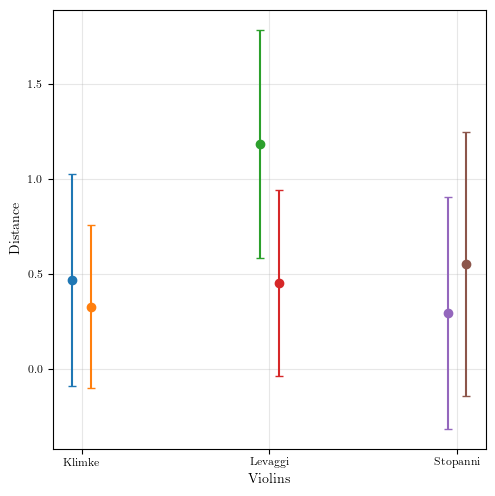

In [91]:
mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, ax = plt.subplots(1, figsize=(5, 5))

for violin_id, violin in enumerate(["A", "B", "C"]):

    for player_id, player in enumerate(["SMD", "Norimi"]):
        entries = df[
            (df.player_a == df.player_b)
            & (df.player_a == player)
            & (df.violin_a == df.violin_b)
            & (df.violin_a == violin)
            & (~df.listener.isin(["Celeste", "Félix", "Norimi"]))
        ]
        d12 = entries[
            (
                (entries.session_a.isin(["1"]) & entries.session_b.isin(["2"]))
                | (entries.session_b.isin(["1"]) & entries.session_a.isin(["2"]))
            )
        ].reset_index()
        d13 = entries[
            (
                (
                    entries.session_a.isin(["1", "2", "1na", "2na"])
                    & entries.session_b.isin(["3"])
                )
                | (
                    entries.session_b.isin(["1", "2", "1na", "2na"])
                    & entries.session_a.isin(["3"])
                )
            )
        ].reset_index()

        display(d13)
        diff = d13.distance - d12.distance
        results = diff.aggregate(["mean", "std", "count"])

        ax.errorbar(
            violin_id + (player_id - 0.5) / 10,
            results["mean"],
            yerr=1.96 / np.sqrt(results["count"]) * results["std"],
            fmt="o",
            capsize=3,
        )

ax.set_ylabel("Distance")
ax.set_xlabel("Violins")
ax.set_xticks([0, 1, 2], ["Klimke", "Levaggi", "Stopanni"])
# ax.set_ylim((4, 8))
fig.show()
# fig.savefig("../reports/figures/tests.png")